In [2]:
from SOH_func import *
import matplotlib.pyplot as pl
from tensorflow import keras
from keras import models, layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
# from sklearn.preprocessing import StandardScaler

# %load_ext tensorboard

In [3]:
FILE_NAME = 'CYCLE_CSV_data.csv'
FILE_01 = 'CYCLE_CSV_data01.csv'
FILE_02 = 'CYCLE_CSV_data02.csv'
# drop_labels = ['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '누적_용량(Ah)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)']
drop_labels_x = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '단위_방전_용량(Ah/g)']

Index(['방전_용량(Ah)', '방전_에너지(Wh)', '방전_최종전압(V)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data = (510, 3)
data_cap = (510, 1)


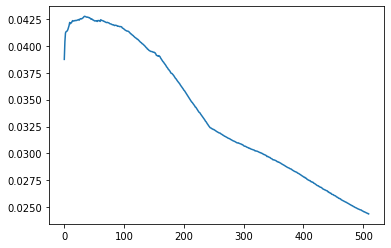

In [4]:
data, data_cap = get_data(FILE_NAME, drop_labels_x, drop_labels_y)
print(f'data = {data.shape}')
print(f'data_cap = {data_cap.shape}')
pl.plot(data_cap)
pl.show()

In [5]:
param = {'seq_len' : 25, 'sample_len' : 25, 'num_units' : 64, 'num_filters' : 64, 'window' : 3, 'drop_rate' : 0.2, 'num_epochs' : 400}
x_train, y_train, num_batch  = seq_gen(data, data_cap, param['seq_len'])
print(x_train.shape)

num_batch = 20
x = (20, 25, 3)
y = (20, 25, 1)
(20, 25, 3)


In [6]:
model = models.Sequential()
model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          640       
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          65        
 ibuted)                                                         
                                                                 
Total params: 33,729
Trainable params: 33,729
Non-trainable params: 0
_________________________________________________________________


In [7]:
epoch_index = 0
loss_dict = {}
epoch_index += param['num_epochs']
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOH_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=param['num_epochs'], verbose = 1, validation_split=0.2, callbacks=callback_list)

Epoch 1/400
1/1 [==============================] - 1s 1s/step - loss: 0.0156 - val_loss: 9.6728e-05
Epoch 2/400
1/1 [==============================] - 0s 20ms/step - loss: 3.6441e-04 - val_loss: 0.0054
Epoch 3/400
1/1 [==============================] - 0s 20ms/step - loss: 0.0043 - val_loss: 0.0088
Epoch 4/400
1/1 [==============================] - 0s 20ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 5/400
1/1 [==============================] - 0s 19ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 6/400
1/1 [==============================] - 0s 32ms/step - loss: 0.0012 - val_loss: 6.6566e-05
Epoch 7/400
1/1 [==============================] - 0s 19ms/step - loss: 3.3092e-05 - val_loss: 4.4466e-04
Epoch 8/400
1/1 [==============================] - 0s 18ms/step - loss: 9.0723e-04 - val_loss: 0.0015
Epoch 9/400
1/1 [==============================] - 0s 21ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/400
1/1 [==============================] - 0s 19ms/step - loss: 0.0028 - val_loss: 0.00

1/1 [==============================] - 0s 212ms/step
(500, 1) (500, 1)
Estimation-64FL-64UN-400EP-25SQ


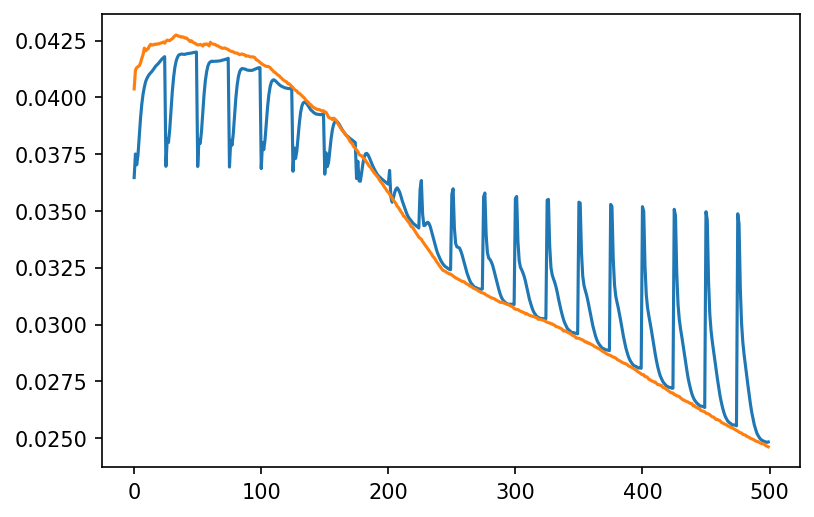

In [8]:
show_and_proof(model, epoch_index, x_train, y_train, loss_dict, param)